In [ ]:
"""
INSTALL REQUIRED PACKAGES
"""

%pip install hmmlearn
%pip install eyed3
%pip install pyAudioAnalysis
%pip install pydub
%pip install librosa
%pip install -U nltk
%python -m nltk.downloader 'popular'
%pip install -U pywsd
%pip install -U wn==0.0.23
%pip install matplotlib
%pip install sklearn
%pip install pandas
%pip install tqdm
%pip install scipy
%pip install nltk

In [56]:
"""
REQUIRED PACKAGES
"""

import os
import sys
import math
import string
import datetime
import glob
import pandas as pd
import numpy as np
from re import A
from pydub import AudioSegment
from pyAudioAnalysis import audioBasicIO as aIO 
from pyAudioAnalysis import ShortTermFeatures
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.fftpack import fft
from scipy.signal import lfilter
from scipy.fftpack.realtransforms import dct
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



/var/folders/by/1njt0mzs3c91ybbjdbrgswvw0000gn/T/ipykernel_38524/3925169921.py:26: DeprecationWarning: Please use `dct` from the `scipy.fftpack` namespace, the `scipy.fftpack.realtransforms` namespace is deprecated.
  from scipy.fftpack.realtransforms import dct


In [57]:
"""
FILENAME HELPER FUNCTION
"""

def find_filenames(path_to_dir, suffix=".wav"):
    filenames = os.listdir(path_to_dir)
    return [os.path.join(path_to_dir, filename) for filename in filenames if filename.endswith(suffix)]

In [58]:
"""
HELPER FUNCTIONS FOR AUDIO FEATURE EXTRACTION
these functions are (mostly) courtesy of pyaudioanalysis
did not import them, as I needed to make adjustments for runtime
purposes (their feature_extraction function computed all 250+ audio
features, when I only needed a few).
"""

eps = sys.float_info.epsilon

def dc_normalize(sig_array):
    """Removes DC and normalizes to -1, 1 range"""
    sig_array_norm = sig_array.copy()
    sig_array_norm -= sig_array_norm.mean()
    sig_array_norm /= abs(sig_array_norm).max() + 1e-10
    return sig_array_norm


def zero_crossing_rate(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero) / np.float64(count - 1.0)


def energy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2) / np.float64(len(frame))


def energy_entropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    # total frame energy
    frame_energy = np.sum(frame ** 2)
    frame_length = len(frame)
    sub_win_len = int(np.floor(frame_length / n_short_blocks))
    if frame_length != sub_win_len * n_short_blocks:
        frame = frame[0:sub_win_len * n_short_blocks]

    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (frame_energy + eps)

    # Compute entropy of the normalized sub-frame energies:
    entropy = -np.sum(s * np.log2(s + eps))
    return entropy


""" Frequency-domain audio features """


def spectral_centroid_spread(fft_magnitude, sampling_rate):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(fft_magnitude) + 1)) * \
          (sampling_rate / (2.0 * len(fft_magnitude)))

    Xt = fft_magnitude.copy()
    Xt_max = Xt.max()
    if Xt_max == 0:
        Xt = Xt / eps
    else:
        Xt = Xt / Xt_max

    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    centroid = (NUM / DEN)

    # Spread:
    spread = np.sqrt(np.sum(((ind - centroid) ** 2) * Xt) / DEN)

    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    spread = spread / (sampling_rate / 2.0)

    return centroid, spread


def spectral_entropy(signal, n_short_blocks=10):
    """Computes the spectral entropy"""
    # number of frame samples
    num_frames = len(signal)

    # total spectral energy
    total_energy = np.sum(signal ** 2)

    # length of sub-frame
    sub_win_len = int(np.floor(num_frames / n_short_blocks))
    if num_frames != sub_win_len * n_short_blocks:
        signal = signal[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = signal.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (total_energy + eps)

    # compute spectral entropy
    entropy = -np.sum(s * np.log2(s + eps))

    return entropy


def spectral_flux(fft_magnitude, previous_fft_magnitude):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        fft_magnitude:            the abs(fft) of the current frame
        previous_fft_magnitude:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + eps)
    previous_fft_sum = np.sum(previous_fft_magnitude + eps)
    sp_flux = np.sum(
        (fft_magnitude / fft_sum - previous_fft_magnitude /
         previous_fft_sum) ** 2)

    return sp_flux


def spectral_rolloff(signal, c):
    """Computes spectral roll-off"""
    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + eps
    a = np.nonzero(cumulative_sum > threshold)[0]
    if len(a) > 0:
        sp_rolloff = np.float64(a[0]) / (float(fft_length))
    else:
        sp_rolloff = 0.0
    return sp_rolloff


def feature_extraction(signal, sampling_rate, window, step, deltas=True):
    """
    This function implements the shor-term windowing process.
    For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        deltas:         (opt) True/False if delta features are to be
                        computed
    RETURNS
        features (numpy.ndarray):        contains features
                                         (n_feats x numOfShortTermWindows)
        feature_names (python list):     contains feature names
                                         (n_feats x numOfShortTermWindows)
    """

    window = int(window)
    step = int(step)

    # signal normalization
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)

    signal = dc_normalize(signal)

    number_of_samples = len(signal)  # total number of samples
    current_position = 0
    count_fr = 0
    num_fft = int(window / 2)

    n_total_feats = 8
    # define list of feature names
    feature_names = ["zcr", "energy", "energy_entropy", 
                     "spectral_centroid", "spectral_spread",
                     "spectral_entropy","spectral_flux","spectral_rolloff"]

    features = []
    # for each short-term window to end of signal
    while current_position + window - 1 < number_of_samples:
        count_fr += 1
        # get current window
        x = signal[current_position:current_position + window]

        # update window position
        current_position = current_position + step

        # get fft magnitude
        fft_magnitude = abs(fft(x))

        # normalize fft
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)

        # keep previous fft mag (used in spectral flux)
        if count_fr == 1:
            fft_magnitude_previous = fft_magnitude.copy()
        
        feature_vector = np.zeros((n_total_feats, 1))

        # zero crossing rate
        feature_vector[0] = zero_crossing_rate(x)

        # short-term energy
        feature_vector[1] = energy(x)

        # short-term entropy of energy
        feature_vector[2] = energy_entropy(x)

        # sp centroid/spread
        [feature_vector[3], feature_vector[4]] = \
            spectral_centroid_spread(fft_magnitude,
                                     sampling_rate)

        # spectral entropy
        feature_vector[5] = \
            spectral_entropy(fft_magnitude)

        # spectral flux
        feature_vector[6] = \
            spectral_flux(fft_magnitude,
                          fft_magnitude_previous)

        # spectral rolloff
        feature_vector[7] = \
            spectral_rolloff(fft_magnitude, 0.90)

        features.append(feature_vector)

        fft_magnitude_previous = fft_magnitude.copy()
        
    features = np.concatenate(features, 1)
    return features, feature_names

In [59]:
"""
HELPER FUNCTIONS FOR LEXICAL FEATURE EXTRACTION
"""

def sentence_lemmatizer_tokenizer(sentence_list):
    """
    Remove inflectional endings of words using wordnet
    (i.e. making sure that 'pained' and 'pain' are not 
    different words for the purposes of sentiment analysis)
    and tokenize sentences into component words.
    """
    lmtzr = WordNetLemmatizer()
    lemmatized = [[lmtzr.lemmatize(word) for word in word_tokenize(s)] 
                 for s in sentence_list]
    return lemmatized


def get_tfidf(sentences):
    """
    Weights the words in a list of sentences according 
    to the tfidf paradigm.
    """
    vec = TfidfVectorizer()
    tf_idf =  vec.fit_transform(sentences)
    return pd.DataFrame(tf_idf.toarray(), columns=vec.get_feature_names_out())


class SplitBySegment():
    """
    Class that matches the sentences in the corpus to their relevant
    timesegment in a particular diarized audio stream
    """
    def __init__(self, filepath,  start_times, end_times, output_dir):
        self.filepath = filepath
        self.audio = AudioSegment.from_wav(self.filepath)
        self.start_times = start_times
        self.end_times = end_times
        self.output_dir = output_dir

    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_sec, to_sec):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        return split_audio
        
    def multiple_split(self):
        for i in range(len(self.start_times)):
            start_time = self.start_times[i]
            end_time = self.end_times[i]
            split = self.single_split(start_time, end_time)
            filename = str(i) + ".wav"
            split.export(os.path.join(self.output_dir, filename), format="wav")

In [60]:
"""
MAIN FUNCTIONS FOR AUDIO AND LEXICAL FEATURE EXTRACTION
"""

def extract_audio_vectors(audio_segment_directory, start_times, end_times, no_affect_index):
    """
    Reads files in from the audio directory, isolates sentences in the audio stream,
    and computes the acoustic features and summarizes them across the sentence.
    """
    win = 0.05
    step = 0.05
    audio_features = []
    for i in range(len(start_times)):
        if i in no_affect_index:
            continue
        else:
            filename = str(i) + ".wav"
            fs, s = aIO.read_audio_file(os.path.join(audio_segment_directory,filename))
            [f, fn] = feature_extraction(s, fs, int(fs * win), int(fs * step))
            summary_stats = [np.average(f[fn.index('energy'), :]),
                             np.max(f[fn.index('energy'), :]),
                             np.average(f[fn.index('energy_entropy'), :]),
                             np.average(f[fn.index('spectral_centroid'), :]),
                             np.average(f[fn.index('spectral_rolloff'), :]),
                             np.average(f[fn.index('zcr'), :])]
            audio_features.append(summary_stats)
    return np.array(audio_features)


def extract_affect_vectors(tokenized_sentences, af_dict):
    """
    Gets the affect vectors from a dictionary of words annotated
    with affect values.
    """
    no_affect_ind = []
    af_vectors = []
    i = 0
    for sentence in tokenized_sentences:
        sentence_vectors = []
        for word in sentence:
            try:
                vec = af_dict[word]
                sentence_vectors.append(vec)
            except:
                continue
        
        if len(sentence_vectors) == 0:
            no_affect_ind.append(i)
        else:
            column_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*sentence_vectors)]
            af_vectors.append(column_average)
        i += 1
    return np.array(af_vectors), no_affect_ind


def extract_features(sentence_directory, audio_directory, audio_segment_directory, af_dict):
    """
    Runs the two functions above to generate the feature matrix and the sentence key that links
    a sentence and timesegment with each row of the feature matrix.
    """
    sentence_filenames = find_filenames(sentence_directory, suffix = ".csv")
    final_features = []
    sentences_full = []
    i = 0
    tfidf = get_tfidf(pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/full_transcripts.csv")["transcript"].tolist())
    for f in sentence_filenames:
        sentences = pd.read_csv(f)
        if len(sentences) == 0:
            print("Not long enough")
            continue
        else:
            sec_start = pd.to_timedelta(sentences[sentences.columns[3]]).dt.total_seconds().apply(np.floor)
            sec_end = pd.to_timedelta(sentences[sentences.columns[4]]).dt.total_seconds().apply(np.ceil)
            pt = pd.concat([sentences['sentence'], sec_start, sec_end, sentences['original_audio']], axis = 1)
            audio_filenames = find_filenames(audio_directory, suffix = ".wav")
            audio_path = os.path.join(audio_directory, pt["original_audio"].iloc[0])
            if audio_path in audio_filenames:
                # Get Affect Vectors
                sentence_list = sentences["sentence"].tolist()
                sentences_lower = [fs.translate(str.maketrans('', '', string.punctuation)).lower() for fs in sentence_list]
                tokenized_sentences = sentence_lemmatizer_tokenizer(sentences_lower)
                af_vectors, no_affect = extract_affect_vectors(tokenized_sentences, af_dict)
                print(af_vectors.shape)
                final_df = pt.drop(pt.index[no_affect])
                rows = final_df.to_numpy()
                for r in rows:
                    sentences_full.append(r)

                # Get Acoustic Vectors
                split_audio = SplitBySegment(audio_path, pt.start_time, pt.end_time, audio_segment_directory)
                split_audio.multiple_split()
                audio_vectors = extract_audio_vectors(audio_segment_directory, pt.start_time, pt.end_time, no_affect)

                if len(af_vectors) != len(audio_vectors):
                    print("ERROR OCCURED")
                else:
                    file_features = np.concatenate((audio_vectors, af_vectors), axis=1)
                    for ff in file_features:
                        final_features.append(ff)
            
                files_to_delete = find_filenames(audio_segment_directory, suffix=".wav")
                if len(files_to_delete) != 0:
                    for t in files_to_delete:
                        os.remove(t)
                print("{} is complete!".format(f))
            else:
                print("not in audio directory")
                continue
    return np.array(final_features), np.array(sentences_full)

In [61]:
"""
LOAD THE AFFECT DATA, LOCATE RELEVANT AUDIO DIRECTORIES, and CLEAR THE TEMPORARY AUDIO SEGMENT DIRECTORY
"""
affect = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/BRM-emot-submit.csv")
af = affect.filter(['Word','V.Mean.Sum','A.Mean.Sum', 'D.Mean.Sum'], axis=1)
af_dict = dict([(i,[x,y,z]) for i,x,y,z in zip(af['Word'], 
                                               af['V.Mean.Sum'],
                                               af['A.Mean.Sum'], 
                                               af['D.Mean.Sum'])])

sentence_directory = "/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentence_transcripts"
audio_directory = "/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/thesis_audio/me_segmented"
audio_segment_directory = "/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/thesis_audio/temp_audio"

files_to_delete = find_filenames(audio_segment_directory, suffix=".wav")
if len(files_to_delete) != 0:
    for f in files_to_delete:
        os.remove(f)

In [62]:
"""
RUN FEATURE EXTRACTION AND SAVE/LOAD RESULTING CSV FILES
"""

FeatureMatrix, sentences_key = extract_features(sentence_directory, audio_directory, audio_segment_directory, af_dict)


#pd.DataFrame(FeatureMatrix).to_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/FeatureMatrix.csv")
#pd.DataFrame(sentences_key).to_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentences_key.csv")

#FeatureMatrix = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/FeatureMatrix.csv").to_numpy()
#sentences_key = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentences_key.csv").to_numpy()


not in audio directory
(89, 3)
/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentence_transcripts/sentence_220326_001_me.csv is complete!
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
(45, 3)
/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentence_transcripts/sentence_220401_002_me.csv is complete!
not in audio directory
(49, 3)
/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/sentence_transcripts/sentence_220312_004_me.csv is complete!
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio directory
not in audio dire

In [63]:
'''
NORMALIZE FEATURE MATRIX
'''
normalized_arr = np.zeros_like(FeatureMatrix)
for i in range(FeatureMatrix.shape[1]):
    v = FeatureMatrix[:,i]
    normalized_arr[:,i] = (v-min(v))/(max(v)-min(v))

In [64]:
'''
CONDUCT PCA ON FEATURE MATRIX
'''
pca = PCA(2)
new = pca.fit_transform(normalized_arr)

In [70]:
"""
FIND IDEAL CLUSTER SIZE USING INERTIA AND SILHOUETTE SCORE 'elbow'
"""

clusters = []

for i in range(2,25):
    k = KMeans(n_clusters=i, n_init=20)
    cluster_labels = k.fit_predict(normalized_arr)
    inertia = k.inertia_
    sil = silhouette_score(normalized_arr, cluster_labels)
    clusters.append([i,inertia,sil])

inertia = pd.DataFrame(clusters, columns = ["Clusters", "Inertia", "Silhouette Score"])

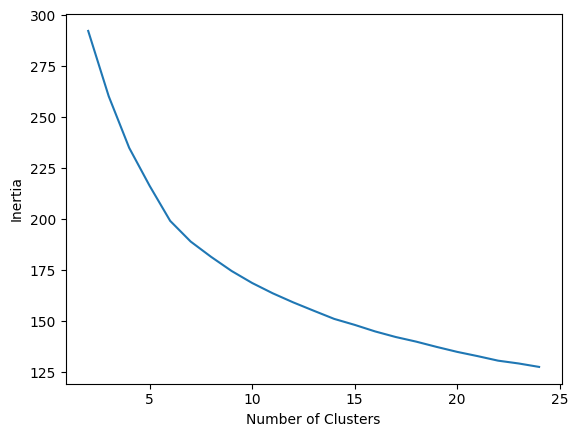

In [71]:
"""
PLOT INERTIA ELBOW
"""

plt.plot(inertia["Clusters"], inertia["Inertia"])
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.savefig('/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/elbow_inertia.png')

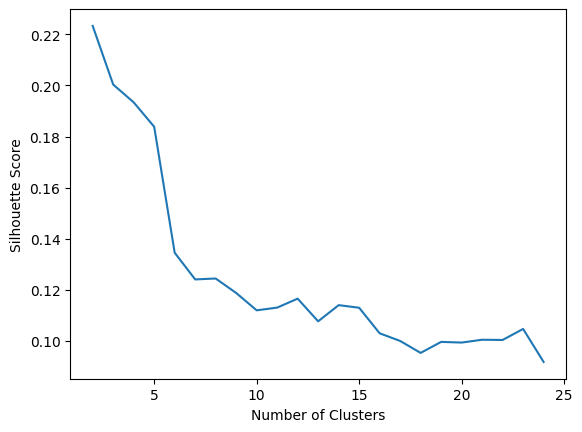

In [72]:
"""
PLOT SILHOUETTE ELBOW
"""

plt.plot(inertia["Clusters"], inertia["Silhouette Score"])
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.savefig('/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/elbow_silhouette.png')

In [68]:
"""
RUN KMEANS CLUSTERING ON THE IDEAL 5-CLUSTER MARK AND CREATE FINAL DATA, 
ATTACHING CLUSTERS TO SENTENCE DATA
"""

k = KMeans(n_clusters=5, n_init=20)
k.fit(normalized_arr)
centroids = k.cluster_centers_
labels = k.labels_
indices = np.expand_dims(labels, axis=1)
cluster_sentence = np.concatenate((indices, sentences_key, new), axis=1)

pd.DataFrame(cluster_sentence).to_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/cluster_sentence.csv")
#cluster_sentence = pd.read_csv("/Users/axelahdritz/coding_projects/Unsupervised-Emotion-Clustering/cluster_sentence.csv").to_numpy()


In [69]:
cluster_sentence

array([[2, 'You should enjoy going to the library today.', 14.0, ...,
        '220326_001_me.wav', -0.20991073907696675, -0.015578072020667716],
       [1, ' The only question I would, we watch Bridget in.', 18.0, ...,
        '220326_001_me.wav', -0.03109505106656163, 0.076000197992468],
       [1, ' That sounds great.', 25.0, ..., '220326_001_me.wav',
        -0.12279369085362028, 0.2732923663215231],
       ...,
       [2,
        ' This is really interesting. But I love you guys. Take answer.',
        1552.0, ..., '220328_001_me.wav', -0.023765342343637683,
        0.01687266742517999],
       [3,
        " Now, and I'll do some therapy. Like what? I meant lose your prescription.",
        1588.0, ..., '220328_001_me.wav', 0.12296490411129554,
        0.0859944285864549],
       [3,
        " I know I'm going to be walking. I'll be around around and yeah, I'm probably just be in my room. I might try to like walking in my room today. I might try to get some food and like make it lo